# Blankenbach Benchmark Case 1

## Steady isoviscous thermal convection

Steady convection with constant viscosity in a square box (l / h =1).
Temperature is fixed to zero on top and to $\Delta T$ at the bottom, no internal heat sources. Reflecting symmetry at the sidewalls, zero shear stress on all boundaries (freeslip).

**References**

B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
boxHeight = 1000. * u.kilometer
boxLength = 1000. * u.kilometer

tempMin = 273.15 * u.degK
tempMax = 1273.15 * u.degK

refViscosity = 1e23 * u.pascal * u.second

KL = boxHeight
KT = (tempMax - tempMin)
Kt = 2000.*u.year
KM = refViscosity * KL * Kt

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[temperature]"]= KT
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"] = KM

In [4]:
Model = GEO.Model(elementRes=(64, 64), 
                  minCoord=(0. * u.kilometer, 0. * u.kilometer), 
                  maxCoord=(1000. * u.kilometer, 1000. * u .kilometer),
                  gravity=(0., -10. * u.meter / u.second**2))

In [ ]:
Model.outputDir = "1_03_BlankenbachBenchmark"

The Blankenbach case 1 benchmark has 3 subcases:
- Case 1(A): $Ra = 10^4$
- Case 1(B): $Ra = 10^5$
- Case 1(C): $Ra = 10^6$

The viscosity of the convecting material is given as the kinematic viscosity which relates to the dynamic density through the density of the material:

$$ \nu = \frac{\eta}{\rho} $$

for a reference density of $4000 \text{kg/m}^3$ this gives:

In [5]:
case1A = 1.0e23 * u.pascal * u.second
case1B = 1.0e22 * u.pascal * u.second
case1C = 1.0e21 * u.pascal * u.second

## Define Material property

We define the density of the material to be temperature dependent using a thermal expansivity of $2.5 \times 10^{-5} \text{/K}^{\circ}$. 

The diffusivity is set to $1 \times 10^6 \text{m}^2 / \text{s}$

In [6]:
Model.density = GEO.LinearDensity(4000. * u.kilogram / u.metre**3, thermalExpansivity=2.5e-5 / u.degK)
Model.diffusivity = 1e-6 * u.metre**2 / u.second
Model.viscosity = case1A

The Raylegh number is defined as 

$$ Ra_0 = \frac{\alpha g \Delta T h^3}{\kappa \mu_0} $$

$\alpha$ is thermal expansion coefficient,
$\kappa$ is diffusivity,
$g$ is gravity,
$dT$ is the difference in temperature between top and bottom,
$h$ is the Model height,
$mu0$.

Let's calculate the Rayleigh number and check that our material properties are correct:

In [7]:
alpha = Model.thermalExpansivity
kappa = Model.diffusivity
g = abs(Model.gravity[-1])
dT = (tempMax - tempMin)
h = Model.height
mu0 = case1A / Model.density.reference_density

Ra0 = (alpha * g * dT * h**3) / (kappa * mu0)

print("Rayleigh Number: {0:6.1f}".format(Ra0.to_base_units()))

Rayleigh Number: 10000.0 dimensionless


## Define velocity boundary conditions

All boundaries have free-slip condition (zero shear stress):

In [8]:
VelocityBCs = Model.set_velocityBCs(left=[0., None], right=[0.,None], top=[None,0.], bottom=[None,0.])

## Define thermal boundary conditions

Temperature is fixed to zero on top and to  Δ𝑇  at the bottom, no internal heat sources.

In [9]:
BoundaryBCs = Model.set_temperatureBCs(top=tempMin, bottom=tempMax)

## Define Initial Temperature perturbation

The initial condition is chosen in order to obtain a single convection cell in the box.

We chose a periodic perturbation:

$$\delta T_{(x,y)} = A\cos\left(\pi \frac{x}{L}\right) \sin{\left(\pi \frac{y}{H}\right)}$$

with $A$ the Amplitude of the perturbation, $L$ and $H$ the dimension of the box.

The initial condition is:

$$T_{(x,y)} = T_{\text{min}} + \Delta T(H - y) + \delta T$$ 

In [10]:
import math

boxLength = GEO.nd(boxLength)
boxHeight = GEO.nd(boxHeight)
tempMin = GEO.nd(tempMin)
tempMax = GEO.nd(tempMax)

Model.temperature.data[:] = 0.
pertStrength = GEO.nd(100. * u.kilometer)
deltaTemp = tempMax - tempMin

for index, coord in enumerate(Model.mesh.data):
    pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
    Model.temperature.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    Model.temperature.data[index] = max(tempMin, min(tempMax, Model.temperature.data[index]))


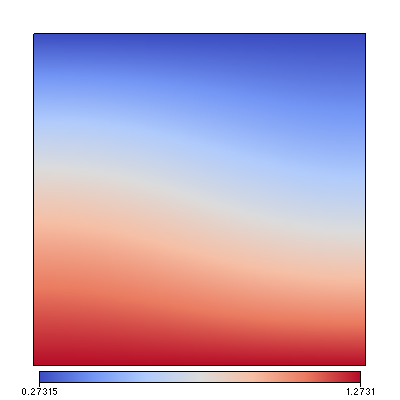

In [11]:
Fig = vis.Figure(figsize=(400,400))
Fig.Surface(Model.mesh, Model.temperature, colours="coolwarm")
Fig.save("Figure_1.png")
Fig.show()

Analysis tools
-----

We define a set of metrics to quantatively measure the evolution of the model: 

**Nusselt number**

The Nusselt number is the ratio between convective and conductive heat transfer

\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]


We thus need to calculate 2 integrals, this can be done using the `uw.utils.Integral` Underworld function:

In [12]:
import underworld as uw

nuTop    = uw.utils.Integral( fn=Model.temperature.fn_gradient[1], 
                              mesh=Model.mesh, integrationType='Surface', 
                              surfaceIndexSet=Model.top_wall)

nuBottom = uw.utils.Integral( fn=Model.temperature,               
                              mesh=Model.mesh, integrationType='Surface', 
                              surfaceIndexSet=Model.bottom_wall)

The Nusselt number is just the ratio:

In [13]:
nu = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]

print('Nusselt number = {0:.6f}'.format(nu))

Nusselt number = 0.785453


**RMS velocity**

The root mean squared velocity is defined by intergrating over the entire simulation domain via

\\[
\begin{aligned}
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]

where $V$ denotes the volume of the box.

In [14]:
import underworld.function as fn

intVdotV = uw.utils.Integral(fn.math.dot(Model.velocityField, Model.velocityField ), Model.mesh )
vrms = math.sqrt( intVdotV.evaluate()[0] )

print('Initial vrms = {0:.3f}'.format(vrms))

Initial vrms = 0.000


Now we need to attach the functions so that they record the evolution of the Model through time. This can be done using the `Model.postSolveHook`:

# PostSolve Hook

In [15]:
# We first define a set of container in the form of python lists.
# We will be recording the time values and the vrms

timeVal = []
vrmsVal = []
nuVal = []

# Define some working variables
velplotmax = 0.0
nuLast     = -1.0

def post_solve_function():

    # The containers must be defined as global variables
    global nuLast
    global timeVal
    global vrmsVal
    global nuVal
    global velplotmax
    
    # Calculate & store the RMS velocity and Nusselt number.
    vrms = math.sqrt( intVdotV.evaluate()[0] )
    nu   = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]
    
    vrmsVal.append(vrms)
    timeVal.append(Model.time)
    nuVal.append(nu)
    
    velplotmax = max(vrms, velplotmax)
    
    # print output statistics 
    if(uw.rank()==0):
        print('v_rms = {0:.3f}; Nu = {1:.3f}; Rel change = {2:.3e}'
              .format(vrms, nu, abs((nu - nuLast)/nu)))
    nuLast = nu

In [16]:
Model.postSolveHook = post_solve_function

In [17]:
Model.init_model(pressure="lithostatic")

In [18]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [19]:
!rm -rf outputs/
Model.run_for(nstep=2)

Running with UWGeodynamics version 0.9.8b-dev-29e4c3b(development)
Step:1 Model Time:  3868257.402443664 year dt: 3868257.402443664 year (2018-11-28 01:43:11)
v_rms = 0.000; Nu = 0.787; Rel change = 2.271e+00
Step:2 Model Time:  7736514.804887328 year dt: 3868257.402443664 year (2018-11-28 01:43:14)
v_rms = 0.000; Nu = 0.788; Rel change = 1.577e-03


1

Post analysis
-----

**Benchmark values**

The time loop above outputs $v_{rms}$ and $Nu$ as general statistics for the system. For comparison, the benchmark values for the RMS velocity and Nusselt number are shown below for different Rayleigh numbers. All benchmark values shown below were determined in Blankenbach *et al.* 1989 by extroplation of numerical results. 


| $Ra$          | $v_{rms}$   | $Nu$  |   $q_1$  | $q_2$  |
| ------------- |:-------------:|:-----:|:-----:|:-----:|
| 10$^4$ | 42.865 |  4.884 | 8.059 | 0.589 |
| 10$^5$ | 193.215 | 10.535 | 19.079 | 0.723 |
| 10$^6$ | 833.990 | 21.972 | 45.964 | 0.877 |


For practicality, quick tests can be run to see that the results are close enough. Tests run using underworld gave

| $Ra$          | $v_{rms}$   | $Nu$  |
| ------------- |:-------------:|:-----:|
| 10$^4$ | 42.858 |  4.848 |
| 10$^5$ | 193.449 | 10.248 |
| 10$^6$ | 844.218 | 19.660 |



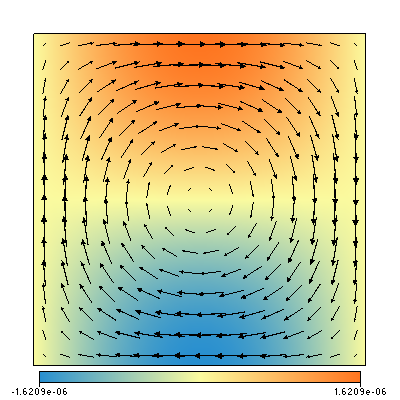

In [20]:
Fig = vis.Figure(figsize=(400,400))
Fig.Surface(Model.mesh, Model.velocityField[0])
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.save("Figure_2.png")
Fig.show()


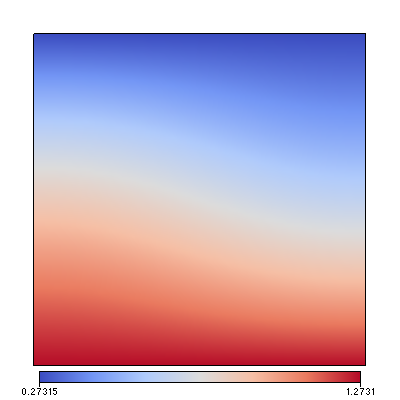

In [21]:
Fig = vis.Figure(figsize=(400,400))
Fig.Surface(Model.mesh, Model.temperature, colours="coolwarm")
Fig.save("Figure_3.png")
Fig.show()